In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patches as patches
import pandas as pd
import scipy.signal as signal
import ipywidgets as widgets

import pims
import cv2 as cv

%matplotlib --list
%matplotlib inline

plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams.update({'font.size':14})

print('\npandas version no.:', pd.__version__)

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']

pandas version no.: 1.4.3


## HTML video (mime type) viewer

In [3]:
%%HTML
<video width="640" controls>
<source src="supplementary_video_3.mp4" type="video/mp4">
</video>

https://soft-matter.github.io/pims/v0.6.1/search.html?q## PIMS version


pixel type is:  uint16 

first frame image:



Frame([[158, 150, 162, ..., 173, 169, 145],
       [154, 157, 148, ..., 198, 163, 130],
       [153, 152, 144, ..., 223, 183, 162],
       ...,
       [200, 195, 187, ..., 174, 132, 138],
       [189, 189, 187, ..., 133, 115, 111],
       [189, 170, 181, ..., 102,  99, 106]], dtype=uint16)
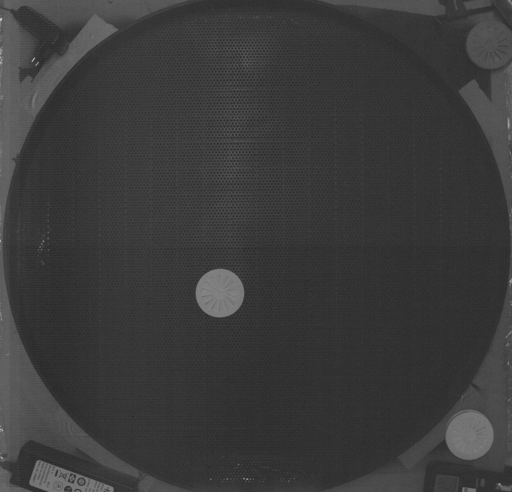

In [4]:
video = pims.Cine('180322/blanca_265.cine')
print('\npixel type is: ', video.pixel_type, '\n')
print('first frame image:\n')
video[0]

In [166]:
def to_time(video_obj):
    
    times = np.array(video_obj.frame_time_stamps).T
    t = np.zeros(video_obj.image_count) 
    s = times[0][0].second
    ns = 0
    for i in range(video_obj.image_count):
        if times[0][i].second != s:
            ns = ns + 1
            s = times[0][i].second
        t[i] = times[1][i] + ns

    t = t - times[1][0]
    
    return t

In [169]:
t = to_time(video)

In [172]:
1/np.mean(np.diff(t)) - video.frame_rate

0.006696489496107461

In [119]:
1/video.frame_rate

0.0013333333333333333

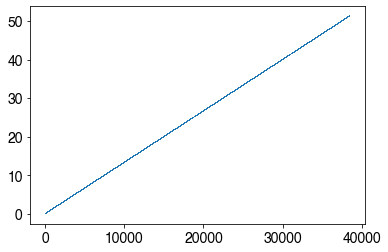

In [110]:
plt.plot(t,',')

### plt.imshow METHOD

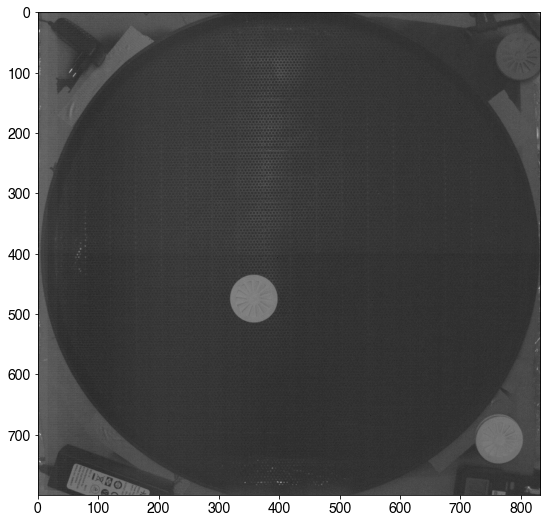

In [550]:
plt.figure(figsize=(9,9))
plt.imshow(np.array(video[100]),cmap='binary_r')


In [174]:
len(video.frame_time_stamps)

38419

In [73]:
video.image_count

38419

In [74]:
video.pixel_type

dtype('uint16')

In [5]:
video.frame_rate_avg

750.0067012877388

In [6]:
video.frame_rate

750

## OPENCV version

### Import video

In [185]:
video_cv = cv.VideoCapture('180322/blanca_265.cine')

In [186]:
video_cv.get(cv.cv2.CAP_PROP_MONOCHROME)

0.0

In [187]:
# NO FUNCIONA EN JUPYTER, solo terminal
def cv_imshow(img):
    while True: 
        cv.imshow('ImageDisplay',img)
        if cv.waitKey(20) & 0xFF == ord('d'):
            cv.destroyAllWindows()
            break

### Read first image

frame has 3  8-bit chanels (RGB), and a resolution of  800 x 832  pixels 



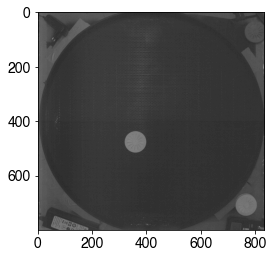

In [297]:
ret, frame = video_cv.read()
print('frame has', np.shape(frame)[2], ' 8-bit chanels (RGB),\
 and a resolution of ', np.shape(frame)[0], 'x', np.shape(frame)[1], ' pixels \n')

image = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
plt.imshow(image, cmap=cm.binary_r)



In [5]:
def read_cine_cv(file):
    video = pims.Cine(file)
    video_cv = cv.VideoCapture(file)
    frames = [[] for i in range(video.image_count)]
    for i in range(video.image_count):
        ret, frames[i] = video_cv.read()
    return video, frames

### Circular mask

In [3]:
def circ_mask(image, R, Rfact):
    ima = np.copy(image)
    X0 = int(np.shape(image)[1]*0.5)
    Y0 = int(np.shape(image)[0]*0.5)
    Y , X = np.ogrid[-Y0:+Y0, -X0:+X0] 
    ima[np.sqrt( X**2 + Y**2) > R * Rfact] = 0
    return ima, image

### Circle detection

	cv.HoughCircles(image, method, dp, minDist, param1, param2, minRadius, maxRadius)
    
( see: https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d)


__im__: input image

__dp__: if dp=1 , the accumulator has the same resolution as the input image. If dp=2 , the accumulator has half as big width and height.

__param1__: edge threshold that will be used by the Canny edge detector (applied to a grayscale image). cvCanny(), internally invoked by cvHoughCircles(), accepts two thresholds. The higher (first) threshold is set to param1 (passed as argument into cvHoughCircles()) and the lower (second) threshold is set to half of this value.

__param2__: Is the value for accumulator threshold. This value is used in the accumulator plane that must be reached so that a line is retrieved.

In [4]:

def locate_disk(im, dp, mD,mr, Mr):
    return cv.HoughCircles(im, cv.HOUGH_GRADIENT, dp, minDist=mD, minRadius=mr, maxRadius=Mr)
    

[357.69998  478.1       44.120003]


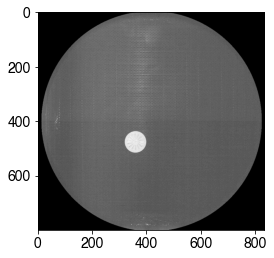

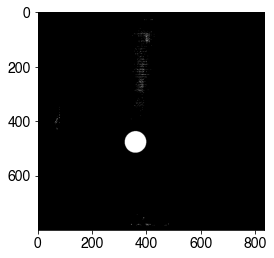

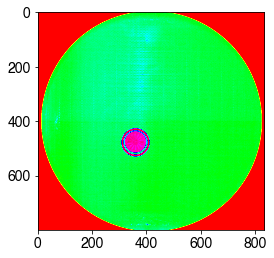

In [5]:
Rfact = 1.01 # factor of increase/decrease system radius
R =  0.5* np.min(np.shape(video[0]))

masked_image, image = circ_mask(cv.convertScaleAbs(video[0]), R, Rfact)

plt.figure()
plt.imshow(masked_image, cmap=cm.binary_r)

circles = None
dp = 1
tR = 45
dfact=2
cs = 2

# Iteratively search for disks, self-adjusting parameters to best fit
while cs>1:
    while circles is None and dp<tR:
        circles = locate_disk(masked_image, dp, dfact*tR, int(tR/2), tR)
        dp = dp + 0.1
    cs = np.shape(circles[0])[0]
    if cs>1: 
        dfact = dfact * 0.95
circles = circles[0,0]

print(circles)

inrange_image = cv.inRange(masked_image, 150, 255)

# Thresholding
plt.figure()
plt.imshow(inrange_image, cmap=cm.binary_r)

x0 = int(circles[0])
y0 = int(circles[1])
r = int(circles[2])

cir_image = np.copy(masked_image)
cv.circle(cir_image, (int(circles[0]),int(circles[1])), int(1.1*r), (255,255,0), 5);
plt.figure()
plt.imshow(cir_image,cmap=cm.hsv)



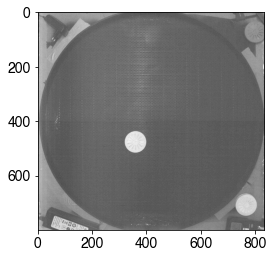

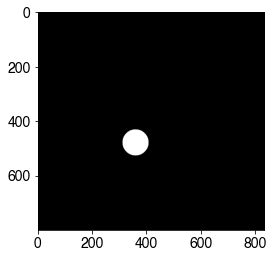

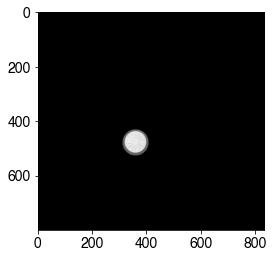

In [15]:

cir_image = np.copy(image)
x0 = int(circles[0])
y0 = int(circles[1])
r = int(circles[2])

plt.figure()
plt.imshow(image,cmap=cm.binary_r)
Mask1 = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
cv.circle(Mask1, (x0, y0), int(1.1*r), (255,255, 255), -1)
plt.figure()
plt.imshow(Mask1, cmap=cm.binary_r)
imm = cv.add(np.zeros(np.shape(image), dtype=np.uint8), image, mask = Mask1)
plt.figure()
plt.imshow(imm, cmap=cm.binary_r)

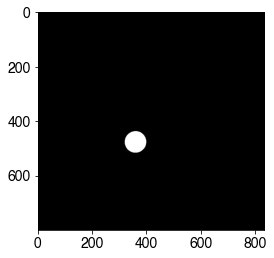

In [49]:
plt.imshow(cv.inRange(imm, 150,255),cmap=cm.binary_r)

In [68]:
locate_disk(cv.inRange(imm, 150,255), 3.1, 100, 30, 45)

array([[[354.94998, 475.84998,  40.23   ]]], dtype=float32)

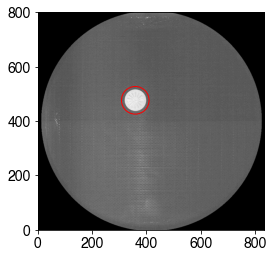

In [32]:

figure, axes = plt.subplots() 

cc = plt.Circle((circles[0], circles[1]), circles[2], edgecolor='r'
                ,facecolor='none' )
plt.xlim(0,832)
plt.ylim(0,800)
axes.add_artist(cc)
plt.imshow(masked_image, cmap=cm.binary_r)


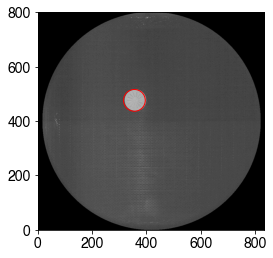

In [400]:
circles = cv.HoughCircles(image, cv.HOUGH_GRADIENT, 1.5, 50
                          ,minRadius=30,maxRadius=50)

figure, axes = plt.subplots() 
cc = plt.Circle((circles[0,0,0], circles[0,0,1]), circles[0,0,2], edgecolor='r'
                ,facecolor='none' )
plt.xlim(0,832)
plt.ylim(0,800)
axes.add_artist(cc)
plt.imshow(masked_image, cmap=cm.binary_r)


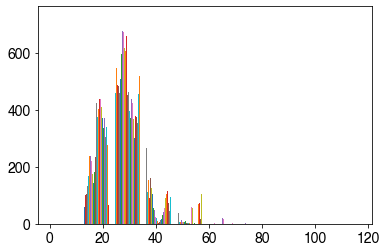

In [102]:
plt.hist(frame.T[0]);

In [142]:
ret, binary_ad = cv.threshold(image,40,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

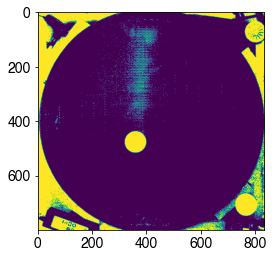

In [143]:
plt.figure()
plt.imshow(binary_ad)

TypeError: 'NoneType' object is not subscriptable

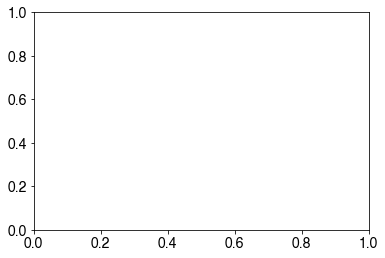

In [144]:
circles = cv.HoughCircles(binary_ad, cv.HOUGH_GRADIENT, 1,1
                          ,minRadius=10,maxRadius=90)

figure, axes = plt.subplots() 
cc = plt.Circle((circles[0,0,0], circles[0,0,1]), circles[0,0,2], edgecolor='r'
                ,facecolor='none' )
plt.xlim(0,800)
plt.ylim(0,832)
axes.set_aspect(1)
axes.add_artist(cc)
plt.imshow(image)

In [184]:
region = np.zeros((np.shape(image)[0], np.shape(image)[1]), dtype=np.uint8)
mask = cv.circle(region, (400,416), 410, 255, -1)

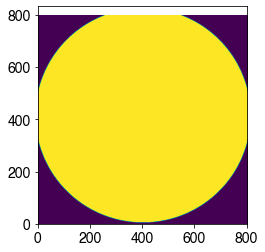

In [185]:
plt.figure()
plt.xlim(0,800)
plt.ylim(0,832)
plt.imshow(mask)



In [169]:
np.shape(image)

(800, 832)

In [159]:
cv.HoughCircles(image, cv.HOUGH_GRADIENT, 2, 300
                          ,minRadius=1, maxRadius=500)

array([[[763. , 709. ,  38. ],
        [355. , 475. ,  41.2]]], dtype=float32)

In [159]:
cv.HoughCircles(image, cv.HOUGH_GRADIENT, 2, 300
                          ,minRadius=1, maxRadius=500)

array([[[763. , 709. ,  38. ],
        [355. , 475. ,  41.2]]], dtype=float32)

In [68]:
np.shape(image)

(800, 832)

In [75]:
circles[0,0,1]

476.25

In [43]:
circles = cv.HoughCircles(image, cv.HOUGH_GRADIENT, 1.5,1
                          ,minRadius=1,maxRadius=90)

In [56]:
circles[0,0,0]

356.25

In [57]:
for i in icircles[0,:]:
    # draw the outer circle
    cv.circle(frame.T[0],(i[0],i[1]),i[2],(0,255,0),2)

error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat (step[ndims-1] != elemsize or step[1] != elemsize*nchannels)
>  - Expected Ptr<cv::UMat> for argument 'img'


In [ ]:
cv2.waitKey(0) 

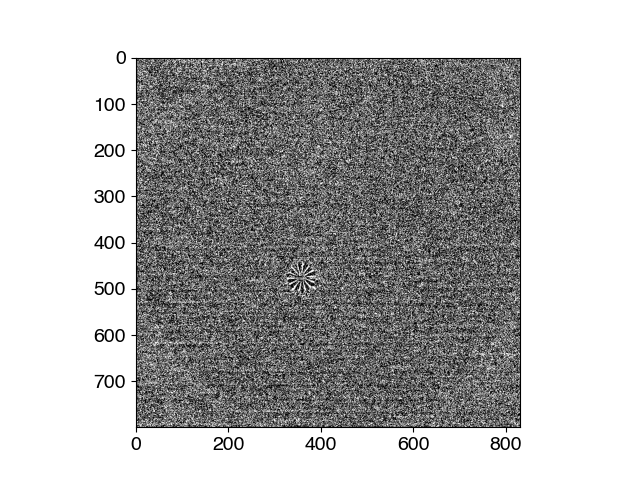

In [14]:
plt.figure(1)
plt.imshow(video[1]-video[0])

In [5]:
datos = pd.read_pickle('tracks/3988fa72e13c390c35b4a55c0495bc63.pkl.xz')
datos = datos[['x','y','frame']]

X = datos.x.values
Y = datos.y.values
it = datos.frame.values
xf = signal.savgol_filter(X, 9, 5)
yf = signal.savgol_filter(Y, 9, 5)
vxf = xf[1:] - xf[:-1]
vyf = yf[1:] - yf[:-1]
xf = xf[:-1]
yf = yf[:-1]

nframes = len(datos)-1

datos.head()


,x,y,frame
0,363.396279,533.013782,1
1,363.571671,533.130123,2
2,363.886110,533.025815,3
3,363.869190,533.091061,4
4,363.420557,533.088331,5


In [6]:
def update(dt):
    plt.close('all')
    fig = plt.figure(figsize=(7.5,6))
    cmm = colors.ListedColormap.reversed(cm.viridis)
    ecolors = (cm.viridis_r((it[::dt]/ it[::dt].max()) ))
    dr = np.max([xf.max()-xf.min(), yf.max()-yf.min()]) *1.1
    plt.xlim(xf.min()*0.9,xf.min()+dr)
    plt.ylim(yf.min()*0.9,yf.min()+dr)
    plt.scatter(xf[::dt], yf[::dt], s=80, facecolors='none', edgecolors=ecolors, linewidths=0.75, alpha=0.75)
    normc = norm = colors.Normalize(vmin=0, vmax=100)
    cbar=plt.colorbar(cm.ScalarMappable(cmap=cm.viridis_r, norm = normc),
                      label= 'time (% of movie length)',orientation="vertical",shrink=0.99)
    #fig.canvas.draw() # with inline
    #fig.show() # with ipympl
    #return fig

In [7]:
plt.close('all')
fig = widgets.interact(update,dt=widgets.BoundedIntText(min=1, max=500, step=1, value=50));

interactive(children=(BoundedIntText(value=50, description='dt', max=500, min=1), Output()), _dom_classes=('wi…

In [9]:
datos.to_csv('tabla.csv')

In [44]:
histx, edgesx = np.histogram(vxf, bins=100, density=True)
histy, edgesy = np.histogram(vyf, bins=100, density=True)
hist, edges = np.histogram(np.sqrt(vxf**2+vyf**2), bins =200, range= (0,1.2),density=True)

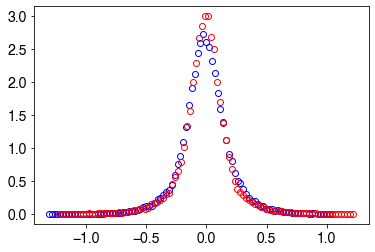

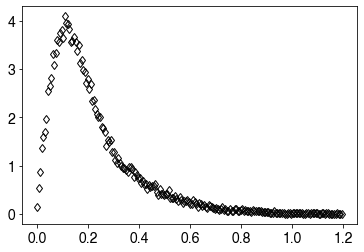

In [47]:
plt.close('all')
plt.figure(2)
plt.plot( edgesx[:-1], histx,'o',mfc='none', mec='b');
plt.plot(edgesy[:-1], histy, 'o', mfc='none',mec='r');
plt.figure(3)
plt.plot(edges[:-1], hist, 'd',c='k',mfc='none');